In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import math

# Descargue la base de datos aqui

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 64

img_transform = transform.Compose([transform.ToTensor(), transform.Normalize((0.5,),(0.5,))])

train_set = torchvision.datasets.MNIST(root = '../../data', train= True, transform= img_transform, download= True)
test_set = torchvision.datasets.MNIST(root = '../../data', train= False, transform= img_transform, download= True)

img, _ = train_set[0]
print(img.shape)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)



cpu
Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:992)>



100%|██████████| 9.91M/9.91M [00:42<00:00, 231kB/s] 


Extracting ../../data\MNIST\raw\train-images-idx3-ubyte.gz to ../../data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:992)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 319kB/s]


Extracting ../../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../../data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:992)>



100%|██████████| 1.65M/1.65M [00:04<00:00, 360kB/s]


Extracting ../../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../../data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:992)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]

Extracting ../../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../../data\MNIST\raw

torch.Size([1, 28, 28])


In [1]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64*2, kernel_size=4, stride=2, padding=1)
    self.fc = nn.Linear(in_features=64*2*7*7, out_features=10)

  def forward(self, image):
    print("image",image.shape)
    out = F.relu(self.conv1(image))
    print("convolucion1",out.shape)
    out = F.relu(self.conv2(out))
    print("convolucion2",out.shape)
    out = out.view(out.size(0), -1)
    print("MLP",out.shape)
    z = self.fc(out)
    return z

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc    = nn.Linear(in_features=10,out_features=2*64*7*7)
    self.convTran1 = nn.ConvTranspose2d(in_channels=2*64,out_channels=64, kernel_size=4, stride=2, padding=1)
    self.convTran2 = nn.ConvTranspose2d(in_channels=64,out_channels=1, kernel_size=4, stride=2, padding=1)

  def forward(self, latent):
    out = self.fc(latent)
    print("MLP",out.shape)
    out = out.view(out.size(0), 64*2, 7, 7)
    print("decon1",out.shape)
    out = F.relu(self.convTran1(out))
    print("decon1",out.shape)
    out = torch.tanh(self.convTran2(out))
    print("decon1",out.shape)
    return out


NameError: name 'nn' is not defined

In [4]:
class Autoencoder(nn.Module):
   def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

   def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return  x_recon

In [5]:
def train(model, train_loader, Epochs, loss_fn):
    train_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      num_batches = 0

      for image_batch, label in train_loader:
          #image_batch_r = image_batch_r.to(device)
          image_batch = image_batch.to(device)
                  #  print(image_batch.size())

          image_batch_recon = model(image_batch)
         # print(image_batch_recon.size())
          loss = loss_fn(image_batch_recon, image_batch)
          #print("el loss es",loss)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_loss_avg[-1] += loss.item()
          num_batches += 1

      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))

    return train_loss_avg

In [6]:

capacity = 64
latent_dims = 10
learning_rate = 0.001
autoencoder = Autoencoder()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()


loss_result = train(autoencoder,train_loader,10,loss)

Epoch [1 / 10] average reconstruction error: 0.103347
Epoch [2 / 10] average reconstruction error: 0.066451
Epoch [3 / 10] average reconstruction error: 0.060815
Epoch [4 / 10] average reconstruction error: 0.057864
Epoch [5 / 10] average reconstruction error: 0.055924


KeyboardInterrupt: 

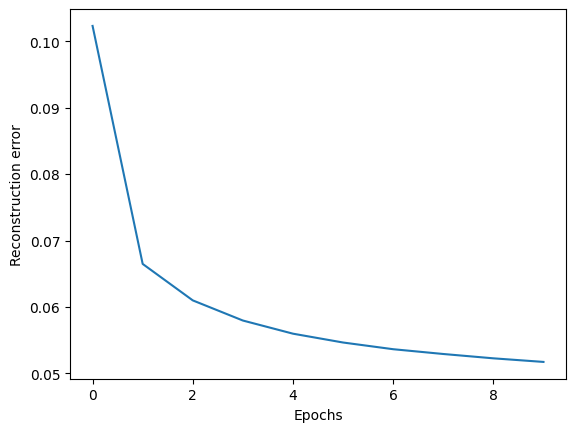

In [ ]:
fig = plt.figure()
plt.plot(loss_result)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [ ]:
def Show(out, title = ''):
  print(title)
  out = out.permute(1,0,2,3)
  grilla = torchvision.utils.make_grid(out,10,5)
  plt.imshow(transform.ToPILImage()(grilla), 'jet')
  plt.show()

def Show_Weight(out):
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transform.ToPILImage()(grilla), 'jet')
  plt.show()

60


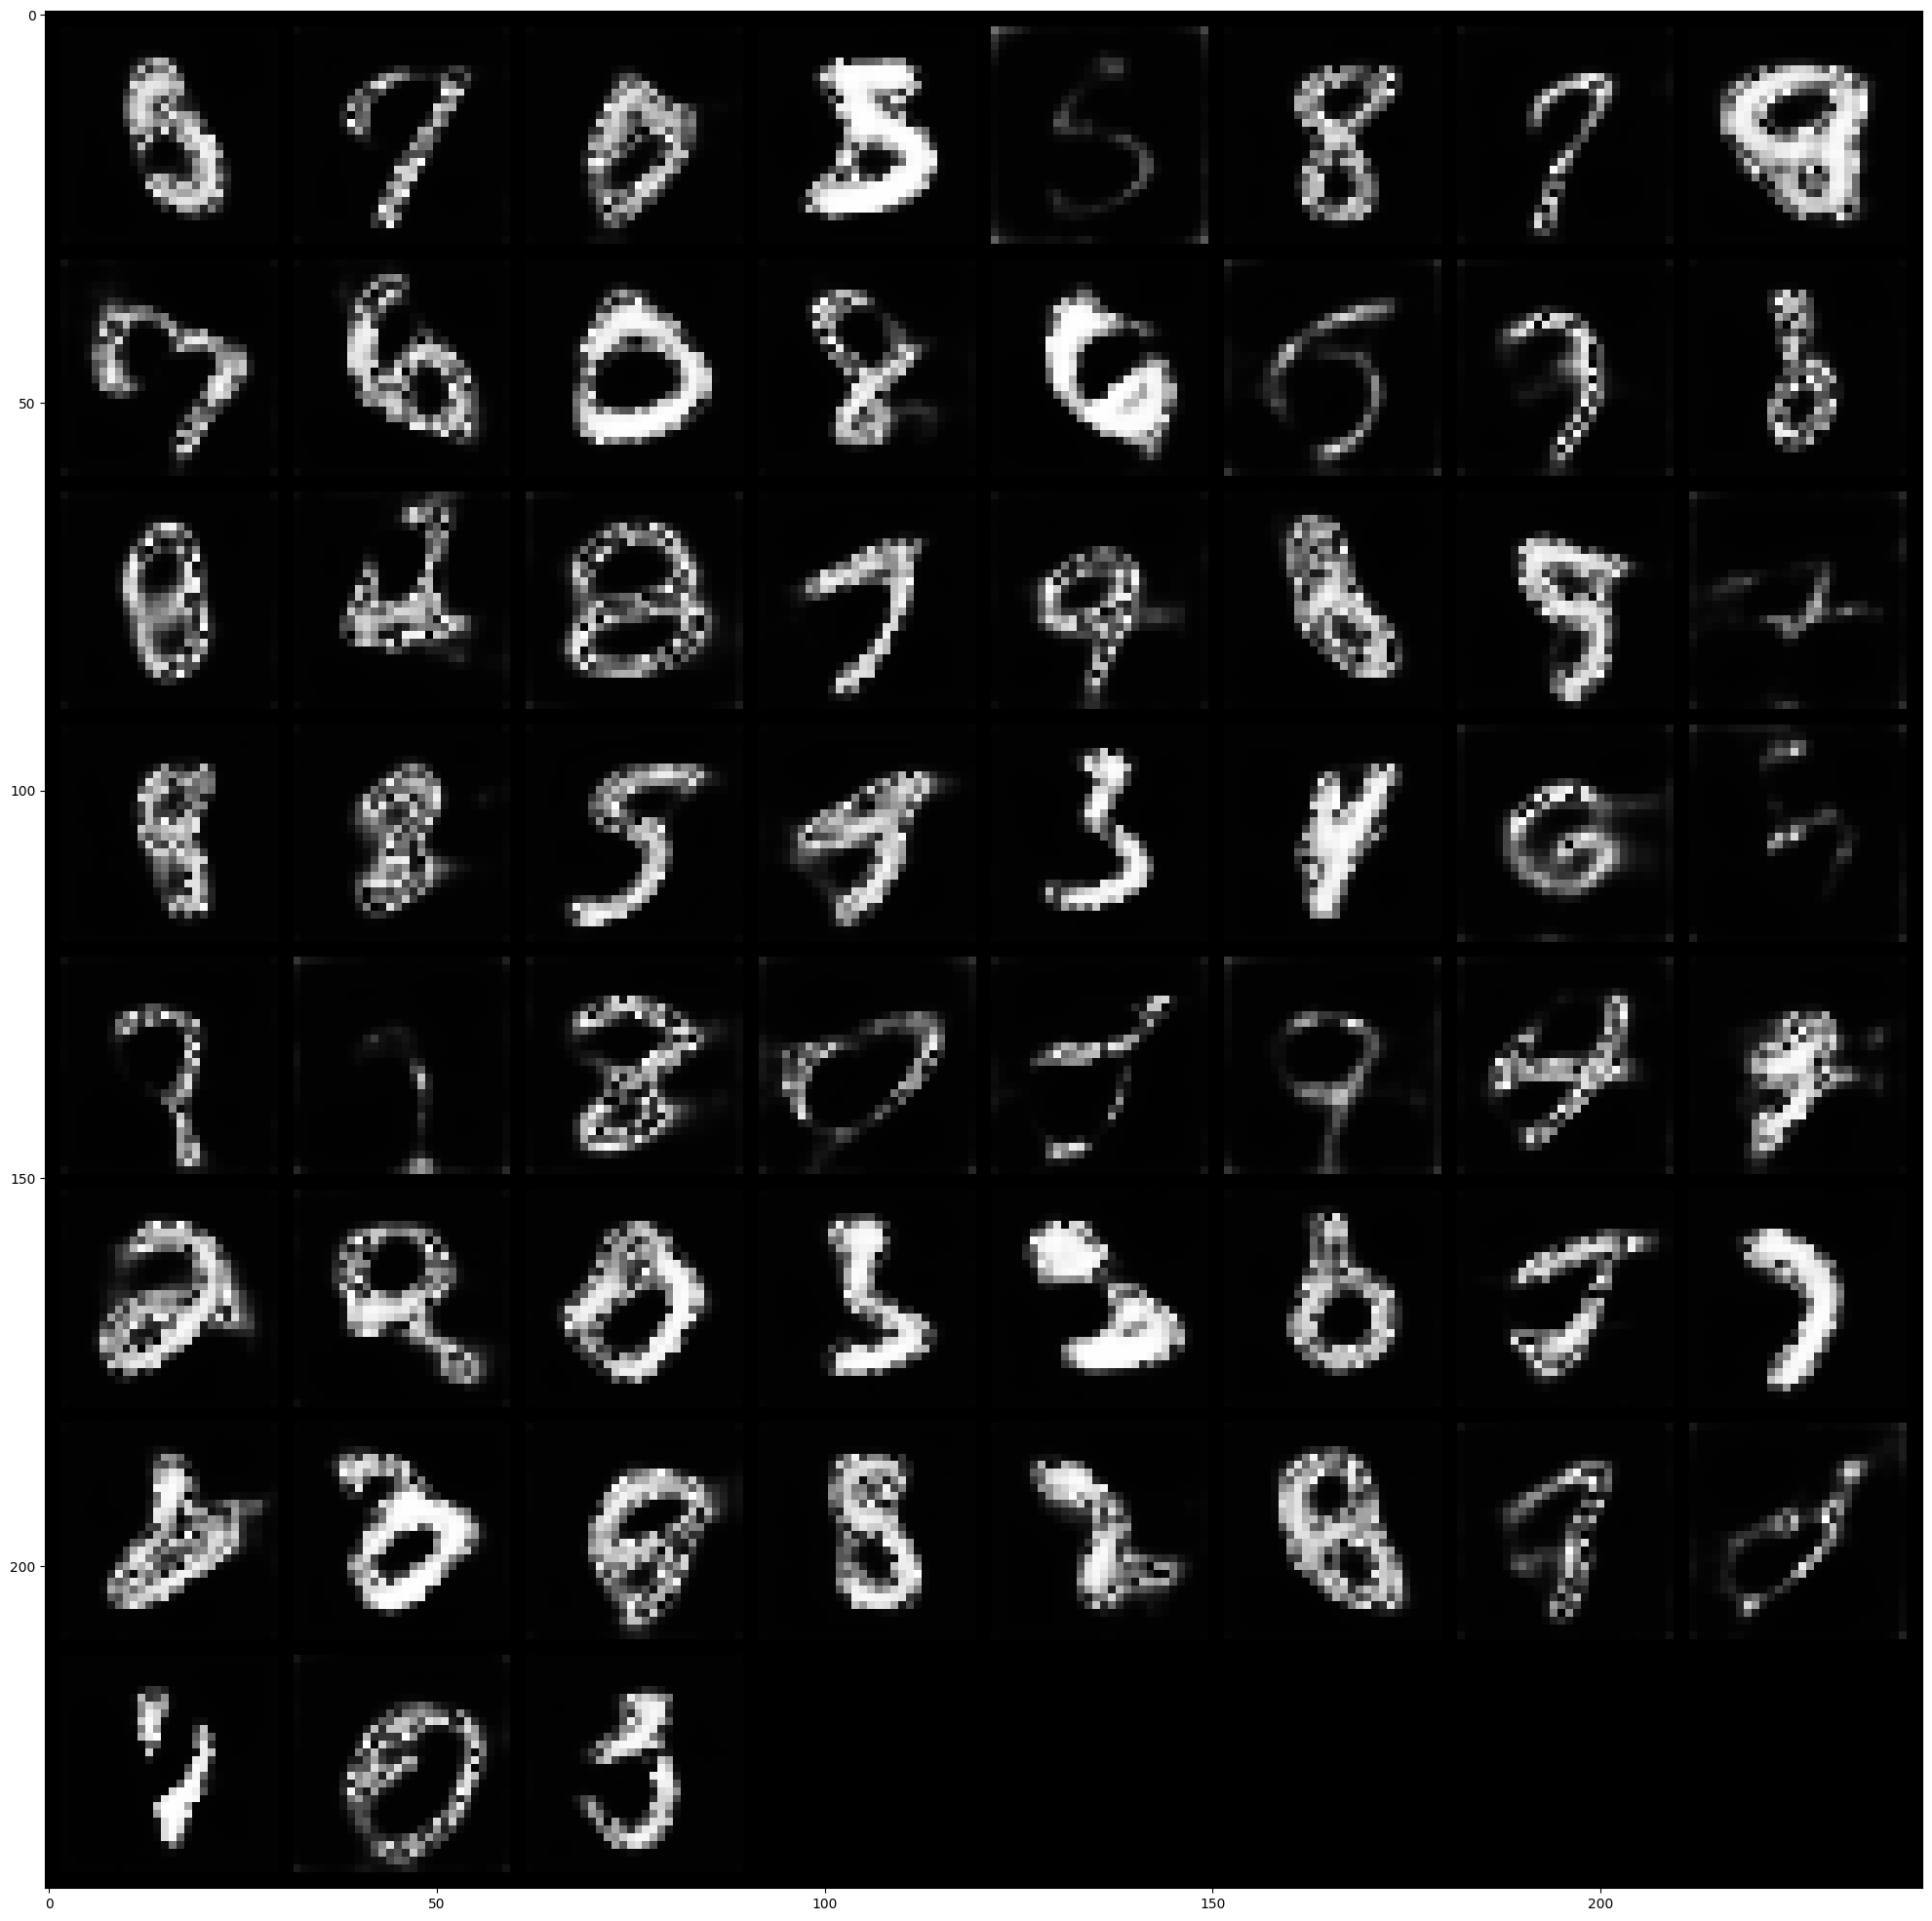

In [ ]:
autoencoder.eval()


tensor = torch.zeros(len(test_loader),10)


with torch.no_grad():

  image,label = next(iter(test_loader))
  image = image.to(device)
  z1 = autoencoder.encoder(image)
  z1 = z1.to('cpu')

  image,label = next(iter(test_loader))
  image = image.to(device)
  z2 = autoencoder.encoder(image)
  z2 = z2.to('cpu')

  image,label = next(iter(test_loader))
  image = image.to(device)
  z3 = autoencoder.encoder(image)
  z3 = z3.to('cpu')

  image,label = next(iter(test_loader))
  image = image.to(device)
  z4 = autoencoder.encoder(image)
  z4 = z4.to('cpu')

  image,label =next(iter(test_loader))
  image = image.to(device)
  z5 = autoencoder.encoder(image)
  z5 = z5.to('cpu')

  image,label =next(iter(test_loader))
  image = image.to(device)
  z6 = autoencoder.encoder(image)
  z6 = z6.to('cpu')

  z = torch.cat((z1,z2,z3,z4,z5,z6),0)

  mean = z.mean(dim=0)

  std = (z - mean).pow(2).mean(dim=0).sqrt()

  z1 = torch.randn(60, latent_dims)*std + mean
  print(len(z1))
  z1 = z1.to(device)
  decodificado = autoencoder.decoder(z1)



  decodificado = decodificado.to('cpu')

  fig, ax = plt.subplots(figsize=(25, 25))
  Show_Weight(decodificado[1:100])
  plt.show()

In [ ]:
from typing_extensions import Required
import sys
model = torchvision.models.vgg19(pretrained=True)
print(torchvision.models)


for e  in model.parameters():
   e.requeres_grad = False



print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 83.9MB/s]


<module 'torchvision.models' from '/usr/local/lib/python3.10/dist-packages/torchvision/models/__init__.py'>
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad